# Neural Prophet Forecasting model

## Dependencies

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from snowflake.snowpark import Session

import warnings

# Ignore only DeprecationWarnings
warnings.filterwarnings('ignore')

from neuralprophet import NeuralProphet

from utils import create_session, mape

## Data Setup

In [45]:
session = create_session()

df = session.table("company_revenue_time_series_1") #with cutoff
df = df.to_pandas()

df = df.rename(columns={'DATE': 'ds', 'REVENUE': 'y'})
df = df[['ds', 'y']] # drop everything but these two if there are any

df['ds'] = pd.to_datetime(df['ds'])
df = df.sort_values(by='ds')
df = df.reset_index(drop=True)

print(df.head())
print(df.info())

# z-score = 2
mean = df['y'].mean()
std = df['y'].std()

z_scores = (df['y'] - mean) / std

threshold = 2
outlier_index = np.where(np.abs(z_scores) > threshold)[0]
print("Dropping "+str(len(outlier_index)) + " rows.")
df.drop(index=outlier_index,inplace=True)

cutoff = round(len(df)*0.8)
train = df[:cutoff]
test = df[cutoff:]

          ds          y
0 2012-03-02  137233.99
1 2012-03-03  190247.55
2 2012-03-04  197809.12
3 2012-03-05  125417.64
4 2012-03-06  120953.92
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364 entries, 0 to 363
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      364 non-null    datetime64[ns]
 1   y       364 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 5.8 KB
None
Dropping 12 rows.


## Simple Neural Prophet

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.582% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 170


Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (18) is too small than the required number                     for the learning rate finder (214). The results might not be optimal.
Finding best initial lr: 100%|██████████| 214/214 [00:02<00:00, 77.78it/s]


Training: |          | 0/? [00:45<?, ?it/s, v_num=34, train_loss=0.0178, reg_loss=0.000, MAE=7.31e+3, RMSE=1.08e+4, Loss=0.0178, RegLoss=0.000]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 92.857% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 92.857% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 53.77it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


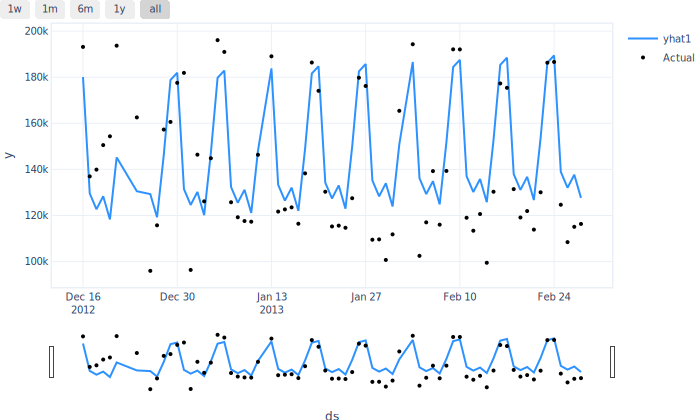

In [46]:
params = {"weekly_seasonality":True}

m = NeuralProphet(**params)

m.set_plotting_backend("plotly-static")  # show plots correctly in jupyter notebooks
metrics = m.fit(train, freq='D')
forecast = m.predict(test)

m.plot(forecast)

In [47]:
nn_prophet_mape = mape(test['y'], forecast['yhat1'])
print(f'Neural Prophet MAPE: {nn_prophet_mape}%')

Neural Prophet MAPE: 10.98%


## Cross Validation

In [48]:
# setup

def cross_validation(params, df):
    folds = NeuralProphet(**params).crossvalidation_split_df(df, freq="D", k=5, fold_pct=0.20, fold_overlap_pct=0.5)
    tests = []
    forecasts = []

    for df_train, df_test in folds:
        m = NeuralProphet(**params)
        m.set_plotting_backend("plotly-static")
        train = m.fit(df=df_train, freq="D")
        forecast = m.predict(df_test)
        test = m.test(df=df_test)
        tests.append(test)
        forecasts.append(forecast)

    return tests, forecasts#, metrics_train, metrics_test


In [49]:
params = {"seasonality_mode": "multiplicative", "learning_rate": 0.1}
cv_metrics, cv_forecast = cross_validation(params, df)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 97.727% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.592% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set ep

Training: |          | 0/? [00:49<?, ?it/s, v_num=35, train_loss=0.0184, reg_loss=0.000, MAE=6.72e+3, RMSE=9.73e+3, Loss=0.0184, RegLoss=0.000]


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.571% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.571% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 133.98it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.571% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D



Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 17.34it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.87% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.01983046531677246
         MAE_val               6765.1015625
        RMSE_val               9236.61328125
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 200


Training: |          | 0/? [00:45<?, ?it/s, v_num=36, train_loss=0.0165, reg_loss=0.000, MAE=6.88e+3, RMSE=9.85e+3, Loss=0.0163, RegLoss=0.000]


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.571% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.571% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 145.79it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.571% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D



Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 16.25it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.057% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test          0.023012271150946617
         MAE_val             7287.98583984375
        RMSE_val                9835.796875
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 190


Training: |          | 0/? [00:40<?, ?it/s, v_num=37, train_loss=0.0168, reg_loss=0.000, MAE=6.52e+3, RMSE=9.64e+3, Loss=0.0162, RegLoss=0.000]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 95.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 95.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 124.82it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 95.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D



Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 13.12it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.19% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 180



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test          0.044398821890354156
         MAE_val              9492.669921875
        RMSE_val             14527.0908203125
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Epoch 190: 100%|██████████| 190/190 [00:00<00:00, 369.37it/s]   
Training: |          | 0/? [00:44<?, ?it/s, v_num=38, train_loss=0.0141, reg_loss=0.000, MAE=6.07e+3, RMSE=9.09e+3, Loss=0.0137, RegLoss=0.000]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 91.429% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 91.429% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 106.83it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 91.429% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D



Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.09it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.582% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.06948276609182358
         MAE_val             12446.3095703125
        RMSE_val              19192.814453125
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 170


Training: |          | 0/? [00:59<?, ?it/s, v_num=39, train_loss=0.0169, reg_loss=0.000, MAE=7e+3, RMSE=1.05e+4, Loss=0.0171, RegLoss=0.000]   

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 92.857% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 92.857% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 150.55it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 92.857% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D



Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.30it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.05634171515703201
         MAE_val             13182.6298828125
        RMSE_val              17540.81640625
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [50]:
combined_forecast = pd.concat(cv_forecast)
print(combined_forecast)
print(f"MAPE: {mape(combined_forecast['y'], combined_forecast['yhat1'])}%")

           ds          y          yhat1          trend  season_weekly
0  2012-07-24  110804.26  110242.859375  127156.210938  -16913.347656
1  2012-07-25  107367.45  114999.179688  127191.500000  -12192.323242
2  2012-07-26  103476.04  106819.570312  127226.796875  -20407.224609
3  2012-07-27  128746.39  129598.585938  127262.093750    2336.494873
4  2012-07-28  151364.59  157807.203125  127297.375000   30509.826172
..        ...        ...            ...            ...            ...
65 2013-02-24  186628.58  204914.656250  151340.546875   53574.097656
66 2013-02-25  124662.95  132694.093750  151470.546875  -18776.458984
67 2013-02-26  108440.70  122175.796875  151600.531250  -29424.738281
68 2013-02-27  115084.81  130698.632812  151730.546875  -21031.912109
69 2013-02-28  116328.96  116026.171875  151860.531250  -35834.371094

[350 rows x 5 columns]
MAPE: 7.08%


## Trying other parameters

Add a parameter for day of month. 

### Data Setup

In [51]:
session = create_session()

df = session.table("company_revenue_time_series_1") #with cutoff
df = df.to_pandas()

df = df.rename(columns={'DATE': 'ds', 'REVENUE': 'y'})
df = df[['ds', 'y', 'day_of_month']] # drop everything but these two if there are any

df['ds'] = pd.to_datetime(df['ds'])
df = df.sort_values(by='ds')
df = df.reset_index(drop=True)

print(df.head())
print(df.info())

# z-score = 2
mean = df['y'].mean()
std = df['y'].std()

z_scores = (df['y'] - mean) / std

threshold = 2
outlier_index = np.where(np.abs(z_scores) > threshold)[0]
print("Dropping "+str(len(outlier_index)) + " rows.")
df.drop(index=outlier_index,inplace=True)

cutoff = round(len(df)*0.8)
train = df[:cutoff]
test = df[cutoff:]

          ds          y  day_of_month
0 2012-03-02  137233.99             2
1 2012-03-03  190247.55             3
2 2012-03-04  197809.12             4
3 2012-03-05  125417.64             5
4 2012-03-06  120953.92             6
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364 entries, 0 to 363
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   ds            364 non-null    datetime64[ns]
 1   y             364 non-null    float64       
 2   day_of_month  364 non-null    int8          
dtypes: datetime64[ns](1), float64(1), int8(1)
memory usage: 6.2 KB
None
Dropping 12 rows.


### Model fitting and forecast

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.582% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 170


Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (18) is too small than the required number                     for the learning rate finder (214). The results might not be optimal.
Finding best initial lr: 100%|██████████| 214/214 [00:04<00:00, 42.96it/s]


Training: |          | 0/? [01:04<?, ?it/s, v_num=40, train_loss=0.0168, reg_loss=0.000, MAE=7.08e+3, RMSE=1.03e+4, Loss=0.0166, RegLoss=0.000]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 92.857% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 92.857% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 52.56it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


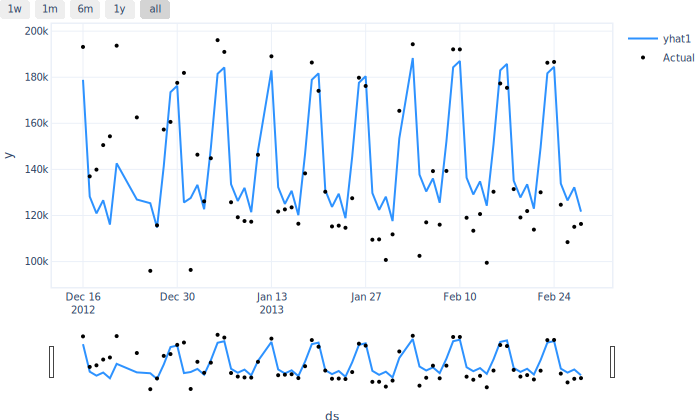

MAPE: 9.83%


In [52]:
params = {"weekly_seasonality":True}

m = NeuralProphet(**params)
m.add_future_regressor('day_of_month')
m.set_plotting_backend("plotly-static")  # show plots correctly in jupyter notebooks
metrics = m.fit(train, freq='D')

forecast = m.predict(test)

m.plot(forecast)
print(f"MAPE: {mape(forecast['y'], forecast['yhat1'])}%")